## Part VI: Natural Language Supervision

We will compare the performance of:

(a) traditional supervision - positive and negative labels on examples

(b) natural language supervision - explanations converted into LFs, which are then denoised and applied to unlabeled data to create a much larger but noisy training set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
os.environ['SNORKELDB'] = 'postgres:///semparse'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

In [3]:
from snorkel.annotations import FeatureAnnotator
featurizer = FeatureAnnotator()

In [4]:
F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_unlabeled   = featurizer.load_matrix(session, split=3)

In [5]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

## (b) Natural Language Supervision

In [6]:
# PYTHON LFs
from pprint import pprint
from python_lfs import get_python_lfs

python_lfs = get_python_lfs()
pprint(python_lfs)
# LFs = python_lfs

[<function LF_distant_supervision at 0x11a1e0aa0>,
 <function LF_distant_supervision_last_names at 0x11a1e0b18>,
 <function LF_husband_wife at 0x11a1e05f0>,
 <function LF_husband_wife_left_window at 0x11a1e0668>,
 <function LF_same_last_name at 0x11a1e06e0>,
 <function LF_no_spouse_in_sentence at 0x11a1e0758>,
 <function LF_and_married at 0x11a1e07d0>,
 <function LF_familial_relationship at 0x11a1e0848>,
 <function LF_family_left_window at 0x11a1e08c0>,
 <function LF_other_relationship at 0x11a1e0938>]


In [7]:
# NL LFs
spouse = ['wife', 'husband', 'ex-wife', 'ex-husband']
family = ['father', 'mother', 'sister', 'brother', 'son', 'daughter',
          'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin']
family = family + [f + '-in-law' for f in family]
coworker = ['boss', 'employee', 'secretary', 'co-worker']

user_lists = {'spouse': spouse,
              'family': family,
              'coworker': coworker}

explanations = [
    "Label false because the number of words between arg 1 and arg 2 is larger than 10",
    "Label false because there is a person between arg 1 and arg 2",
    "Label true because there is at least one spouse word in the words between arg 1 and arg 2",
    "Label true because there is at least one spouse word within two words to the left of arg 1 or arg 2",
    "Label false because there are no spouse words in the sentence",
    "Label true because the word 'and' is between arg 1 and arg 2 and 'married' is to the right of arg 2",
    "Label false because there is at least one family word between arg 1 and arg 2",
    "Label false because there is at least one family word within two words to the left of arg 1 or arg 2",
    "Label false because there is at least one coworker word between arg 1 and arg 2",
    "Label false because arg 1 is identical to arg 2",
]

In [8]:
from snorkel.semantic.parser import SemanticParser

sp = SemanticParser()
LFs = sp.parse(explanations, user_lists=user_lists, verbose=True)

Created grammar with 148 rules
13 LFs created from 10 explanations


In [9]:
for lf in LFs:
    print lf

<function exp0_parse0 at 0x11b636c80>
<function exp1_parse0 at 0x11c191410>
<function exp2_parse0 at 0x11c19e9b0>
<function exp3_parse0 at 0x11c1b3b90>
<function exp4_parse0 at 0x11c1b66e0>
<function exp5_parse0 at 0x11c1cc500>
<function exp5_parse1 at 0x11c1ccde8>
<function exp6_parse0 at 0x11ca18938>
<function exp6_parse1 at 0x11ca24230>
<function exp7_parse0 at 0x11ca37e60>
<function exp8_parse0 at 0x11ca3e410>
<function exp8_parse1 at 0x11ca40758>
<function exp9_parse0 at 0x11ca40c80>


### Investigate one LF

In [10]:
# lf = LFs[4]
# print lf

In [11]:
# labeled = []
# for c in session.query(Spouse).filter(Spouse.split == 3).all():
#     try:
#         if lf(c) != 0:
#             labeled.append(c)
#     except:
#         pass
# print "Number labeled:", len(labeled)

In [12]:
# from snorkel.viewer import SentenceNgramViewer

# sv = SentenceNgramViewer(labeled[:300], session)
# sv

In [13]:
# from snorkel.lf_helpers import test_LF
# tp, fp, tn, fn = test_LF(session, lf, split=0, annotator_name='gold')

### Apply all LFs

In [14]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(f=LFs)

In [15]:
np.random.seed(1701)
%time L_unlabeled = labeler.apply(split=3)
L_unlabeled

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 1s, sys: 1.35 s, total: 1min 3s
Wall time: 1min 15s


<4780x13 sparse matrix of type '<type 'numpy.float64'>'
	with 8734 stored elements in Compressed Sparse Row format>

In [16]:
L_unlabeled.lf_stats(session, )

,j,Coverage,Overlaps,Conflicts
exp0_parse0,0,0.393515,0.389749,0.023431
exp1_parse0,1,0.258787,0.257113,0.018619
exp2_parse0,2,0.036820,0.029916,0.023640
exp3_parse0,3,0.020711,0.017992,0.011925
exp4_parse0,4,0.929289,0.467782,0.002510
exp5_parse0,5,0.002929,0.002929,0.002720
exp5_parse1,6,0.002929,0.002929,0.002720
exp6_parse0,7,0.051255,0.051255,0.007531
exp6_parse1,8,0.051255,0.051255,0.007531
exp7_parse0,9,0.027406,0.026778,0.001674


### Generative Model

In [17]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_unlabeled, epochs=500, decay=0.95, step_size=0.1/L_unlabeled.shape[0], reg_param=1e-6)

In [18]:
train_marginals = gen_model.marginals(L_unlabeled)

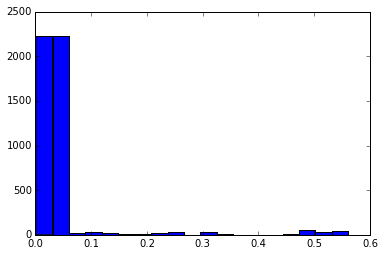

In [19]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [20]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [21]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.417
Neg. class accuracy: 0.978
Precision            0.417
Recall               0.417
F1                   0.417
----------------------------------------
TP: 5 | FP: 7 | TN: 315 | FN: 7



In [22]:
L_dev.lf_stats(session, L_gold_dev, gen_model.weights.lf_accuracy())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
exp0_parse0,0,0.398204,0.395210,0.029940,0,0,3,127,0.976923,0.653984
exp1_parse0,1,0.281437,0.281437,0.032934,0,0,3,90,0.967742,0.605098
exp2_parse0,2,0.068862,0.053892,0.035928,10,13,0,0,0.434783,0.513208
exp3_parse0,3,0.035928,0.032934,0.014970,6,6,0,0,0.500000,0.517149
exp4_parse0,4,0.886228,0.449102,0.008982,0,0,2,289,0.993127,0.830904
exp5_parse0,5,0.008982,0.008982,0.008982,1,2,0,0,0.333333,0.517013
exp5_parse1,6,0.008982,0.008982,0.008982,1,2,0,0,0.333333,0.515533
exp6_parse0,7,0.029940,0.029940,0.002994,0,0,0,10,1.000000,0.537478
exp6_parse1,8,0.029940,0.029940,0.002994,0,0,0,10,1.000000,0.537213
exp7_parse0,9,0.029940,0.023952,0.002994,0,0,1,9,0.900000,0.528035


### Discriminative Model

In [23]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()

In [24]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_unlabeled, train_marginals, [rate_param, l1_param, l2_param], n=20)

Initialized RandomSearch search of size 20. Search space size = 125.


In [28]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=True, print_freq=25)

[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=152  #epochs=50  batch size=100
[SparseLR] Epoch 0 (0.20s)	Avg. loss=0.677195	NNZ=3025
[SparseLR] Epoch 25 (0.31s)	Avg. loss=0.475742	NNZ=3025
[SparseLR] Epoch 49 (0.43s)	Avg. loss=0.457101	NNZ=3025
[SparseLR] Training done (0.43s)
[SparseLR] Model saved. To load, use name
		SparseLR_0
[2] Testing lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-03
[SparseLR] lr=0.0001 l1=1e-06 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=152  #epochs=50  batch size=100
[SparseLR] Epoch 0 (0.20s)	Avg. loss=0.684048	NNZ=3025
[SparseLR] Epoch 25 (0.32s)	Avg. loss=0.661457	NNZ=3025
[SparseLR] Epoch 49 (0.43s)	Avg. loss=0.643269	NNZ=3025
[SparseLR] Training done (0.43s)
[3] Testing lr = 1.00e-03, l1_penalty = 1.00e-05, l2_penalty = 1.00e-05
[SparseLR] lr=0.001 l1=1e-05 l2=1e-05
[Spa

,lr,l1_penalty,l2_penalty,Prec.,Rec.,F1
17,0.010000,0.000010,0.000001,0.666667,0.166667,0.266667
4,0.010000,0.000100,0.000010,0.500000,0.166667,0.250000
7,0.010000,0.000010,0.010000,0.500000,0.166667,0.250000
19,0.010000,0.000010,0.000100,0.333333,0.166667,0.222222
0,0.010000,0.001000,0.000100,0.222222,0.166667,0.190476
9,0.000001,0.000010,0.001000,0.032727,0.750000,0.062718
16,0.000001,0.010000,0.001000,0.030651,0.666667,0.058608
5,0.000001,0.001000,0.000010,0.028409,0.416667,0.053191
18,0.000010,0.010000,0.000001,0.028302,0.250000,0.050847
6,0.000001,0.001000,0.010000,0.016000,0.166667,0.029197


In [ ]:
# disc_model.train(F_unlabeled, train_marginals, n_epochs=20, lr=0.001)

In [30]:
TP, FP, TN, FN = disc_model.score(session, F_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.167
Neg. class accuracy: 0.997
Precision            0.667
Recall               0.167
F1                   0.267
----------------------------------------
TP: 2 | FP: 1 | TN: 321 | FN: 10



In [33]:
type(list(TP)[0])

snorkel.models.candidate.Spouse